In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_train_G3tdtEn.csv')

test_Dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_test_8skS2ey.csv')

data_Y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/Y_train_2_XPXJDyy.csv')

df = dataframe.copy()

## change of the categorical data to numbers

list_uniqueLabel = []
list_col_object = []
list_dic_map = []
# Loop for that assign a each unique categorical value a number and after it reeplace the categorical value for this number
for col in df.columns:
    if df[col].dtypes == object:
        list_col_object.append(col)

for count in range(0,4):

    concate = pd.concat([dataframe[colum] for colum in list_col_object[(count*24):((count+1)*24)]])
    concate = pd.concat([test_Dataframe[columt] for columt in list_col_object[(count*24):((count+1)*24)]])
    concate = pd.concat([pd.Series([np.nan]),concate])

    list_uniqueLabel.append(concate.unique())

    # dictionary
    dic_map = {label : index for index, label in enumerate(list_uniqueLabel[-1])}

    # Replace the values in dataframe

    for colob in range(0,24):
        df[list_col_object[colob+count*24]] = df[list_col_object[colob+count*24]].map(dic_map)

    list_dic_map.append(dic_map.copy())
    dic_map.clear()


<ipython-input-3-45892081aa21>:1: DtypeWarning: Columns (21,22,23,24,69,70,71,72,93,94,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_train_G3tdtEn.csv')
<ipython-input-3-45892081aa21>:3: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  test_Dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_test_8skS2ey.csv')


In [4]:
# Reemplace the 0 in the converted columns to his true value NaN
df[list_col_object] = df[list_col_object].replace(0,np.nan)

# Verification exact coincidence

exact_coincidence = (df['ID'] == data_Y['ID']).all()
print(exact_coincidence)

# we put out the columns that not contribute to the prediction

df = df.drop('ID',axis=1)
data_Y = data_Y.drop(['index','ID'], axis=1)

True


In [5]:
dataX = np.array(df)
dataY = np.array(data_Y)

print(dataX.shape)
print(dataY.shape)

print(np.sum(np.isnan(dataX)))

(92790, 145)
(92790, 1)
12415322


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Remplace the NaN values

constant_imputer = SimpleImputer(strategy='constant')
dataX_imp = constant_imputer.fit_transform(dataX)

# normalizacion

scaler = MinMaxScaler(feature_range=(0, 1))
dataX_n = scaler.fit_transform(dataX_imp)

# Split of the data for validation set

# training_input_t,val_input,training_output_t,val_output = train_test_split(dataX_n, data_Y, test_size=0.2)

training_input_t,training_output_t = dataX_n,data_Y



# split of data for test

# training_input_t,test_input,training_output_t,test_output = train_test_split(training_input_t, training_output_t, test_size=0.1)



In [7]:
# database of just values with 1

index_db_1 = training_output_t.index[training_output_t['fraud_flag']==1].to_list()

database_1 = training_input_t[index_db_1]

print(database_1.shape)

(1319, 145)


Dimensionality Reduction

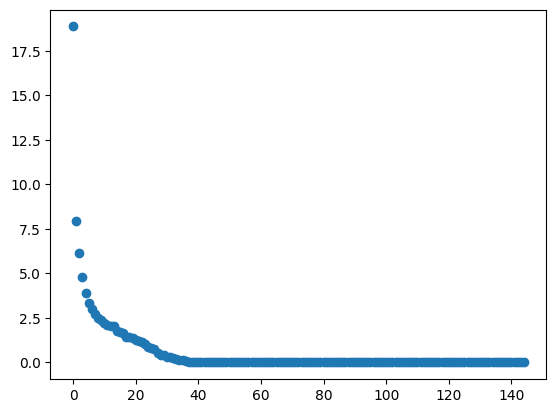

In [8]:
import matplotlib.pyplot as plt

u, s, vh = np.linalg.svd(database_1) # s sont les valeur propes associées a la transpossée de A

list_x = range(len(s))
plt.scatter(list_x,s)
plt.show()

GAN model

4/4 [==============================] - 0s 3ms/step
399 0.7599999904632568 0.0


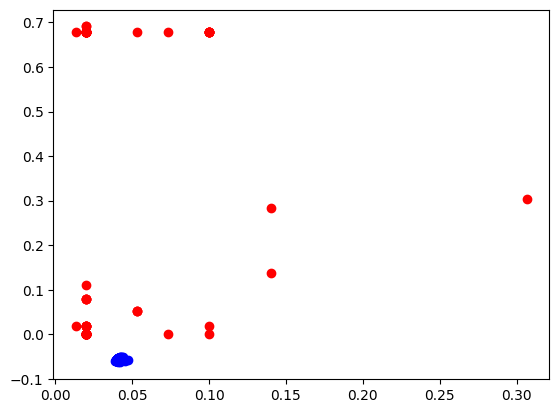

4/4 [==============================] - 0s 3ms/step
799 0.949999988079071 0.0


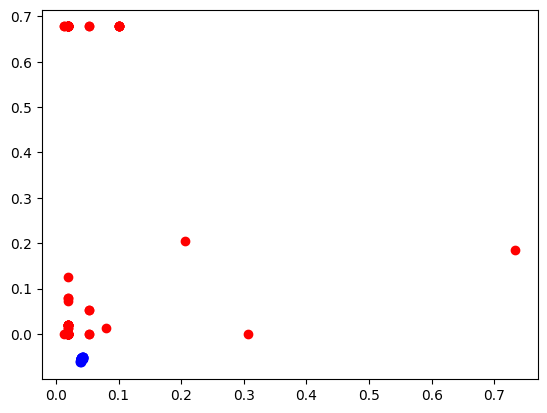

4/4 [==============================] - 0s 3ms/step
1199 0.9599999785423279 0.0


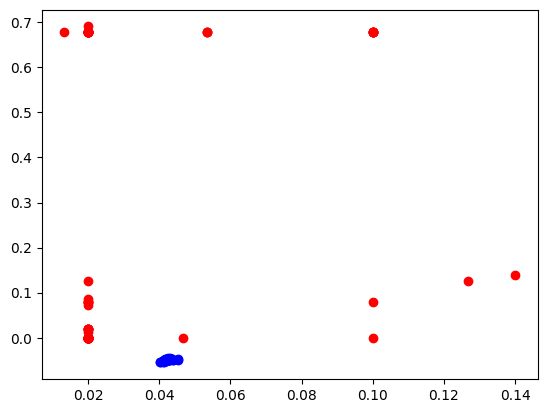

4/4 [==============================] - 0s 3ms/step
1599 0.9700000286102295 0.0


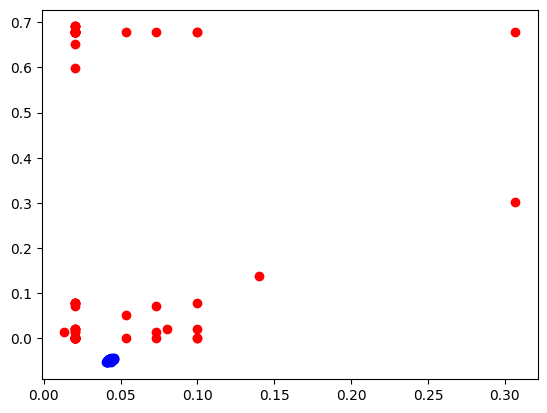

4/4 [==============================] - 0s 3ms/step
1999 0.9800000190734863 0.0


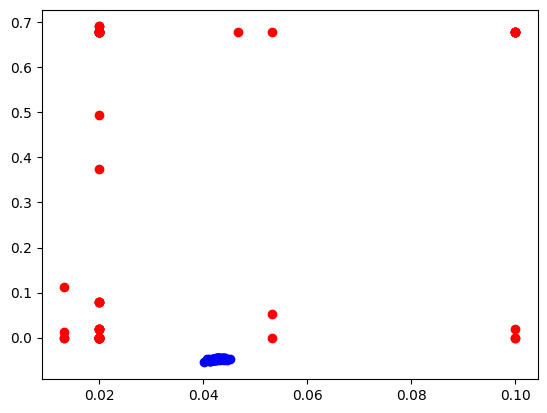

In [9]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
import tensorflow as tf
from keras.layers import Dropout

# define the standalone discriminator model
def define_discriminator(n_inputs=145):
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(n_inputs,)))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(200,activation='tanh'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(250,activation='selu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(500,activation='elu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(250,activation='selu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(150,activation='relu'))
    model.add(Dense(1,activation='sigmoid')) # Output
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# define the standalone generator model
def define_generator(latent_dim, n_outputs=145):
 model = Sequential()
 model.add(Dense(40, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
 model.add(Dense(60, activation='elu'))
 model.add(Dense(160, activation='selu'))
 model.add(Dropout(0.2))
 model.add(Dense(180, activation='tanh'))
 model.add(Dense(200, activation='gelu'))
 model.add(Dense(185, activation='elu'))
 model.add(Dropout(0.2))
 model.add(Dense(170, activation='relu'))
 model.add(Dense(n_outputs, activation='linear'))
 return model


# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
 # make weights in the discriminator not trainable
 discriminator.trainable = False
 # connect them
 model = Sequential()
 # add generator
 model.add(generator)
 # add the discriminator
 model.add(discriminator)
 # compile model
 model.compile(loss='binary_crossentropy', optimizer='adam')
 return model


# generate n real samples with class labels from the dataset
def generate_real_samples(n):
    # Index of the data
    ind = np.random.choice(len(database_1), n, replace=False)
    X = database_1[ind]
    # generate class labels
    y = ones((n, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input


 # use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

# evaluate the discriminator and plot real and fake points (Performance evaluation of the model)(The discriminator is suposed to have a performance about 50% because the objectif is make a generator that could confuse the discriminator)
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0) # _ is the loss of the model
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n) # fake examples generated for the generator of the GAN
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0) # _ is the loss of the model
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()

 # train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=2000, n_batch=400, n_eval=400):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    ########################

    for i in range(n_epochs):
        # generate real examples
        X_real, y_real = generate_real_samples(half_batch)
        # generate fake examples
        X_fake, y_fake = generate_fake_samples(g_model,latent_dim,half_batch)
        # update the discriminator
        d_model.train_on_batch(X_real,y_real)
        d_model.train_on_batch(X_fake,y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan,y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

    ########################

# size of the latent space
latent_dim = 35
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [10]:
# Sampling Fake data with GAN

m = len(training_output_t[training_output_t['fraud_flag'] == 0]) - len(training_output_t[training_output_t['fraud_flag'] == 1])
m = int(0.2 * m)

x_fake, y_fake = generate_fake_samples(generator,latent_dim,m)

training_input = np.vstack((training_input_t,x_fake))
training_output_t = np.array(training_output_t)
training_output = np.vstack((training_output_t,y_fake))

564/564 [==============================] - 2s 4ms/step


In [11]:
# Split of the data for validation and training set

training_input_t,test_input,training_output_t,test_output = train_test_split(training_input, training_output, test_size=0.1)

training_input,val_input,training_output,val_output = train_test_split(training_input_t, training_output_t, test_size=0.222)


In [12]:
import tensorflow as tf

# Function to improve the learning rate

def adapt_learning_rate(epoch):
    lr=0.001
    if epoch>100:
        lr=0.0001
    if epoch>200:
        lr=0.00005
    if epoch>240:
        lr=0.00001
    if epoch>700:
        lr=0.000005

    return lr

my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [13]:
# Neural Network

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# Network

model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(145,)))
model.add(Dense(100,activation='relu'))
model.add(Dense(200,activation='tanh'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(250,activation='selu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(500,activation='elu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(250,activation='selu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(150,activation='relu'))
model.add(Dense(1,activation='sigmoid')) # Output

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 100)               14600     
                                                                 
 dense_16 (Dense)            (None, 200)               20200     
                                                                 
 batch_normalization_4 (Bat  (None, 200)               800       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_17 (Dense)            (None, 250)               50250     
                                                                 
 batch_normalization_5 (Bat  (None, 250)               1000      
 chNormalization)                                     

In [14]:
from sklearn.metrics import average_precision_score

# Define the metric average_precision as a personalised function
def average_precision(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.float64)

In [15]:
import tensorflow as tf
from keras.losses import Loss
import keras.backend as K
from tensorflow.python.ops import math_ops

class CustomLossMSFE_Orig(Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        # Obtain index for y_true where it's 0
        indices_y_true_equals_0 = tf.where(tf.equal(y_true, 0)[:, 0])

        # Filter y_true and y_pred with the founded index
        y_true_0 = tf.gather(y_true, indices_y_true_equals_0)
        y_pred_0 = tf.gather(y_pred, indices_y_true_equals_0)

        # Calcul of number of samples where y_true is 0
        n = tf.cast(tf.shape(y_true_0)[0], dtype=tf.float32)

        # uncomment for give more learning to majority class
        # n = 0.8 * n

        # Convert tensors to float32
        y_true_0 = tf.cast(y_true_0, dtype=tf.float32)
        y_pred_0 = tf.cast(y_pred_0, dtype=tf.float32)

        # Calcul of the addition of the mean squared errors for each neuron with y_true equal 0
        diff_0 = math_ops.squared_difference(y_true_0, y_pred_0)
        diff_0 = diff_0 / 2

        red_sum_0 = tf.reduce_sum(diff_0)

        # Obtain index for y_true where it's 1
        indices_y_true_equals_1 = tf.where(tf.equal(y_true, 1)[:, 0])

        # Filter y_true and y_pred with the founded index
        y_true_1 = tf.gather(y_true, indices_y_true_equals_1)
        y_pred_1 = tf.gather(y_pred, indices_y_true_equals_1)

        # Calcul of number of samples where y_true is 1
        p = tf.cast(tf.shape(y_true_1)[0], dtype=tf.float32)
        # p = 0.5 * p

        # Convert tensors to float32
        y_true_1 = tf.cast(y_true_1, dtype=tf.float32)
        y_pred_1 = tf.cast(y_pred_1, dtype=tf.float32)

        # Calcul of the addition of the mean squared errors for each neuron with y_true equal 0
        diff_1 = math_ops.squared_difference(y_true_1, y_pred_1)
        diff_1 = diff_1 / 2

        red_sum_1 = tf.reduce_sum(diff_1)

        # Calcul of the loss with the addition of both errors
        loss = (red_sum_0 / n)**2 + (red_sum_1 / p)**2

        return loss

In [16]:
model.compile(optimizer='adam',
                loss=CustomLossMSFE_Orig(),
                metrics=[average_precision])

In [17]:
# Weights for the learning for each target label

weights = {0:1, 1:1} # 7 Label (1) have 100 times more importance in the learning than label (0)

In [18]:
history1 = model.fit(training_input,training_output,batch_size=800,epochs=40,
                    shuffle=True,callbacks=my_lr_scheduler,validation_data=(val_input,val_output))

# history1 = model.fit(training_input,training_output,batch_size=800,epochs=70,
#                     shuffle=True,callbacks=my_lr_scheduler,class_weight=weights)



Epoch 1/40
97/97 [==============================] - 9s 17ms/step - loss: 0.0313 - average_precision: 0.0328 - val_loss: 0.0275 - val_average_precision: 0.0349 - lr: 0.0010
Epoch 2/40
97/97 [==============================] - 2s 17ms/step - loss: 0.0251 - average_precision: 0.0492 - val_loss: 0.0254 - val_average_precision: 0.0443 - lr: 0.0010
Epoch 3/40
97/97 [==============================] - 2s 17ms/step - loss: 0.0239 - average_precision: 0.0488 - val_loss: 0.0247 - val_average_precision: 0.0454 - lr: 0.0010
Epoch 4/40
97/97 [==============================] - 2s 19ms/step - loss: 0.0212 - average_precision: 0.0565 - val_loss: 0.0228 - val_average_precision: 0.0537 - lr: 0.0010
Epoch 5/40
97/97 [==============================] - 1s 13ms/step - loss: 0.0203 - average_precision: 0.0589 - val_loss: 0.0266 - val_average_precision: 0.0488 - lr: 0.0010
Epoch 6/40
97/97 [==============================] - 1s 12ms/step - loss: 0.0190 - average_precision: 0.0641 - val_loss: 0.0207 - val_average

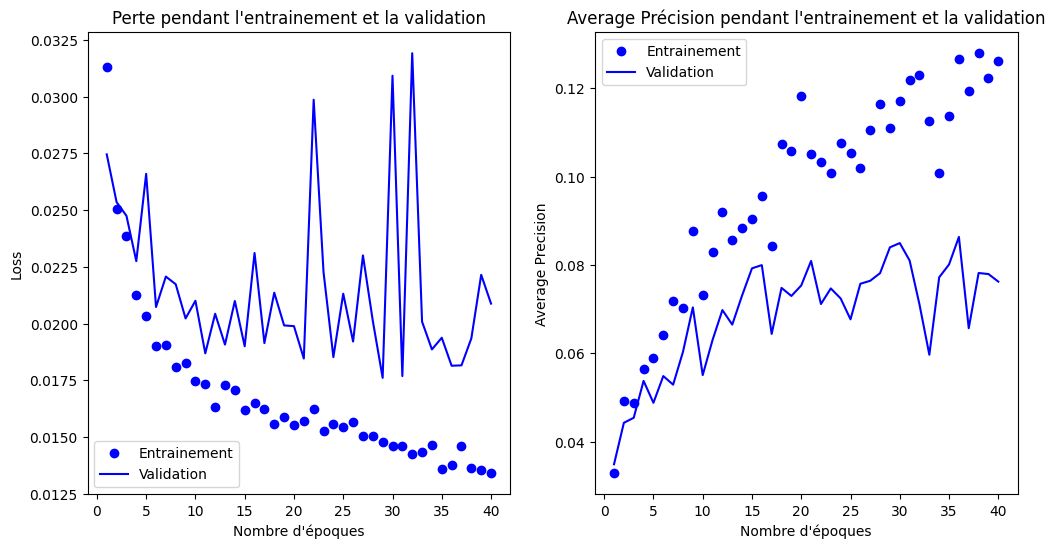

In [19]:
# Visualization of the model _ WITH VALIDATION DATA

import matplotlib.pyplot as plt

# plot fonction perte

loss=history1.history['loss']

val_loss = history1.history['val_loss']
epochs = range(1,len(loss)+1)

plt.figure(figsize=(12,6))


plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label = 'Entrainement')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Perte pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Loss')
plt.legend()

# plot precision du model

avp = history1.history['average_precision']
val_avp = history1.history['val_average_precision']

plt.subplot(1,2,2)
plt.plot(epochs,avp,'bo',label='Entrainement')
plt.plot(epochs, val_avp, 'b', label='Validation')
plt.title('Average Précision pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Average Precision')
plt.legend()
plt.savefig('loss_accuracy_model.jpg')
plt.show()

In [20]:
# # Visualization of the model _ WITHOUT VALIDATION DATA

# import matplotlib.pyplot as plt

# # plot fonction perte

# loss=history1.history['loss']

# # val_loss = history1.history['val_loss']
# epochs = range(1,len(loss)+1)

# plt.figure(figsize=(12,6))


# plt.subplot(1,2,1)
# plt.plot(epochs, loss, 'bo', label = 'Entrainement')
# # plt.plot(epochs, val_loss, 'b', label='Validation')
# plt.title('Perte pendant l\'entrainement et la validation')
# plt.xlabel('Nombre d\'époques')
# plt.ylabel('Loss')
# plt.legend()

# # plot precision du model

# avp = history1.history['average_precision']
# # val_avp = history1.history['val_average_precision']

# plt.subplot(1,2,2)
# plt.plot(epochs,avp,'bo',label='Entrainement')
# # plt.plot(epochs, val_avp, 'b', label='Validation')
# plt.title('Average Précision pendant l\'entrainement et la validation')
# plt.xlabel('Nombre d\'époques')
# plt.ylabel('Average Precision')
# plt.legend()
# plt.savefig('loss_accuracy_model.jpg')
# plt.show()

In [21]:
# Validation of model performance with new data

y_pred = model.predict(test_input)

counter_p = len([valor for valor in y_pred if valor > 0.5])
counter_r = len([valor_r for valor_r in test_output if valor_r > 0.5])
print('There are ',counter_p, ' labels (1) predicted')
print('There are ',counter_r, ' labels (1) in the reality')

print('Neural Network PR-AUC = ',average_precision_score(test_output,y_pred))

y_pred_int = [1 if value > 0.5 else 0 for value in y_pred]

print('Neural Network PR-AUC (binary) = ',average_precision_score(test_output,y_pred_int))

347/347 [==============================] - 1s 2ms/step
There are  2954  labels (1) predicted
There are  156  labels (1) in the reality
Neural Network PR-AUC =  0.0815171950507052
Neural Network PR-AUC (binary) =  0.03158922632701041


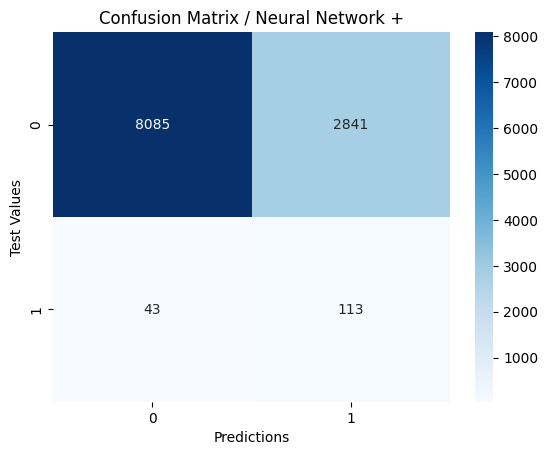

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

prediction = (y_pred > 0.5).astype(int)

# Uncomment to view the model's Confusion Matrix

conf_matrix_features = confusion_matrix(test_output, prediction)

sns.heatmap(conf_matrix_features, annot = True, fmt = 'd', cmap='Blues')

plt.xlabel('Predictions')
plt.ylabel('Test Values')
plt.title('Confusion Matrix / Neural Network +')
plt.savefig('conf_matrix_NeuralNetwork.jpg')
plt.show()

TRATMENT OF THE TEST DATA

In [23]:
test_Dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_test_8skS2ey.csv')
test = test_Dataframe.copy()

# Loop for that assign a each unique categorical value a number and after it reeplace the categorical value for this number

for count_1 in range(0,4):

    # dictionary
    dic_map_1 = list_dic_map[count_1]

    # Replace the values in dataframe

    for colob_1 in range(0,24):
        test[list_col_object[colob_1+count_1*24]] = test[list_col_object[colob_1+count_1*24]].map(dic_map_1)


<ipython-input-23-ca161c5edde8>:1: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  test_Dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_test_8skS2ey.csv')


In [24]:
# Reemplace the 0 in the converted columns to his true value NaN
test[list_col_object] = test[list_col_object].replace(0,np.nan)

# we put out the columns that not contribute to the prediction
test = test.drop('ID',axis=1)


In [25]:
dataX = np.array(test)

print(dataX.shape)

print(np.sum(np.isnan(dataX)))

(23198, 145)
3095028


In [26]:
# Remplace the NaN values

constant_imputer = SimpleImputer(strategy='constant')
dataX_imp = constant_imputer.fit_transform(dataX)

# normalizacion

scaler = MinMaxScaler(feature_range=(0, 1))
dataX_test = scaler.fit_transform(dataX_imp)

PREDICTION AND GENERATION OF THE Y TEST

In [27]:
# Prediction

y_pred = model.predict(dataX_test)

counter_p = len([valor for valor in y_pred if valor > 0.5])
print('There are ',counter_p, ' labels (1) predicted')

Y_test = pd.DataFrame(np.column_stack([test_Dataframe['ID'],y_pred]),columns=['ID','fraud_flag'])
Y_test.to_csv('Y_test.csv', index=True,index_label='index')
print(y_pred)

725/725 [==============================] - 2s 2ms/step
There are  5155  labels (1) predicted
[[0.40310985]
 [0.1935792 ]
 [0.48752093]
 ...
 [0.697331  ]
 [0.14887358]
 [0.6805432 ]]
